# Showcase Project: Numerical Methods for Exotic Derivatives

Instead of a traditional resume or cover letter, I wanted to showcase a hands-on project that demonstrates my ability to structure, price, and analyze exotic derivatives using numerical methods. This project highlights my abilities in applying theoretical concepts to practical problems in the derivatives space, particularly for exotic products such as barrier options, cliquets, variance swaps, and correlation-based structures. By no means does this project cover all aspects of derivatives pricing, but I hope it serves as a useful starting point for discussions about my skills and interests.

The goal of this notebook is not to serve as an exhaustive analysis or a purely academic exercise but rather to showcase my ability to:
- Implement numerical techniques like Monte Carlo simulation and finite difference methods.
- Handle complex derivative structures and path-dependent payoffs.
- Build reusable pricing frameworks for both vanilla and exotic options.

This project reflects my understanding of designing structured products to meet client needs while managing risk effectively. It also demonstrates my ability to work with numerical models that are critical for pricing and risk management in a trading environment. Although it might not be perfect or exhaustive, I hope this notebook sparks interesting conversations about the challenges and nuances of pricing exotic derivatives. Please feel free to skip sections that may seem too basic (e.g., vanilla options pricing) and focus on the parts most relevant to your interests.

Table of Contents:
1. Vanilla Options Pricing via Trees
    - Binomial Trees
    - Trinomial Trees
2. Finite Difference Methods
    - Crank-Nicolson Method
3. Monte Carlo
    - Naive Monte Carlo
    - Antithetic Variates
4. Exotics
    - Barrier Options
        - Barrier Options via Crank-Nicolson
        - Barrier Options via Monte Carlo
    - Correlation Products
        - Worst-of Put Options
        - Dispersion Options

Notes on the Project:
- Technical Complexity:
    We will try not to delve deeply into the mathematical concepts behind each method, but rather focus on the implementation and results. The goal is to provide a clear understanding of how each pricing method works.
- Code Design Philosophy:
    The code is written with clarity and functionality in mind. While I strive for readability, the focus here is on demonstrating the workings of each pricing method rather than creating a production-ready library.
- Greeks Calculation:
    While Greeks are essential for risk management, I have omitted their implementation here for brevity. They can be easily computed by perturbing input parameters (e.g., delta by shifting the underlying price) and recalculating prices.

Cheers!

## Basic Set-up

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import bisect, brentq
from scipy.sparse import diags, lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import norm
import scipy.linalg as linalg
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Optional, Tuple, List
from enum import Enum

We will use some SPX data throughout this project as much as possible to make it more realistic and also so we can compare our results to market prices. Let us pull some SPX data and the 3M implied volatility data that we can then use to price our options.

In [4]:
%%time

spx = yf.Ticker("^SPX")
vix3m = yf.Ticker("^VIX3M")
rfr = yf.Ticker("^IRX")

print(spx.info["open"], vix3m.info["open"], rfr.info["open"])

6115.52 17.86 4.21
CPU times: user 117 ms, sys: 19.8 ms, total: 137 ms
Wall time: 773 ms


## Pricing Vanilla Options with Trees
We do a simple European and American options pricing with Binomial and Trinomial Trees. But first, let us price our options using the Black-Scholes model so that we can compare the results.

In [5]:
class European:
    def __init__(self, K: float, T: float, is_call: bool) -> None:
        self.K = K #strike
        self.T = T #time to mat
        self.is_call = is_call

@dataclass
class MarketData:
    S: float
    r: float
    q: float
    sigma: float

class BlackScholes:
    @staticmethod
    def price(option: European, market: MarketData) -> float:
        d1 = (np.log(market.S / option.K) + (market.r - market.q + 0.5 * market.sigma ** 2) * option.T) / (market.sigma * np.sqrt(option.T))
        d2 = d1 - market.sigma * np.sqrt(option.T)
    
        if option.is_call:
            price = market.S * np.exp(-market.q * option.T) * norm.cdf(d1) - option.K * np.exp(-market.r * option.T) * norm.cdf(d2)
        else:
            price = -market.S * np.exp(-market.q * option.T) * norm.cdf(-d1) + option.K * np.exp(-market.r * option.T) * norm.cdf(-d2)

        return price
    
    @staticmethod
    def greeks(option: European, market: MarketData) -> dict:
        d1 = (np.log(market.S / option.K) + (market.r - market.q + 0.5 * market.sigma ** 2) * option.T) / (market.sigma * np.sqrt(option.T))
        d2 = d1 - market.sigma * np.sqrt(option.T)

        # Delta
        if option.is_call:
            delta = np.exp(-market.q * option.T) * norm.cdf(d1)
        else:
            delta = np.exp(-market.q * option.T) * norm.cdf(-d1)

        # Gamma
        gamma = (norm.pdf(d1) * np.exp(-market.q * option.T)) / (market.S * market.sigma * np.sqrt(option.T))

        # Theta
        theta_1 = -(market.S * norm.pdf(d1) * market.sigma * np.exp(-market.q * option.T)) / (2 * np.sqrt(option.T))

        if option.is_call:
            theta = theta_1 - market.r * option.K * np.exp(-market.r * option.T) * norm.cdf(d2) + market.q * market.S * np.exp(-market.q * option.T) * norm.cdf(d1)
        else:
            theta = theta_1 + market.r * option.K * np.exp(-market.r * option.T) * norm.cdf(-d2) - market.q * market.S * np.exp(-market.q * option.T) * norm.cdf(-d1)

        # Vega
        vega = market.S * np.sqrt(option.T) * norm.pdf(d1) * np.exp(-market.q * option.T)

        return {
            'delta': delta,
            'gamma': gamma,
            'vega': vega,
            'theta': theta
        }
        

Now, using our data we pulled from yfinance, let's price a European put options using the Black-Scholes model.

In [6]:
%%time

option = European(K = spx.info['open']*0.95, T = 0.25, is_call = False) # put option
market = MarketData(S = spx.info['open'], r = rfr.info["open"]/100, q = 0, sigma = vix3m.info["open"]/100)

bs_price = BlackScholes.price(option, market)
print(f'Black Scholes Price: {bs_price:.2f}')

Black Scholes Price: 76.61
CPU times: user 1.35 ms, sys: 689 µs, total: 2.04 ms
Wall time: 2.84 ms


Now that we have a price to compare with let us try this with a binomial tree.

In [7]:
class BinomialTree:
    @staticmethod
    def price(option: European, market: MarketData, N: int, american: bool = False) -> float:
        dt = option.T / N
        
        u = np.exp(market.sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((market.r - market.q) * dt )- d) / (u - d) 
        
        Sgrid = market.S * (u ** np.arange(N, -1, -1)) * (d ** np.arange(N + 1))

        if option.is_call:
            prices = np.maximum(Sgrid - option.K, 0)
            payoff = lambda x: np.maximum(x - option.K, 0)
        else:
            prices = np.maximum(option.K - Sgrid, 0)
            payoff = lambda x: np.maximum(option.K - x, 0)
        
        for i in range(N):
            j_values = np.arange(N-i-1, -1, -1)
            Sgrid = market.S * (u ** j_values) * (d ** ((N-i-1) - j_values))

            prices = np.exp(-market.r * dt) * (p * prices[:-1] + (1 - p) * prices[1:])
            
            #check for early exercise
            if american:
                prices = np.maximum(prices, payoff(Sgrid))
        
        return prices[0]

In [8]:
%%time

binomial_price = BinomialTree.price(option, market, N = 5000)
print(f"Binomial Tree Price: {binomial_price}")

Binomial Tree Price: 76.61329465255517
CPU times: user 537 ms, sys: 5.39 ms, total: 542 ms
Wall time: 544 ms


We see that clearly for European options we have a better pricing speed with the Black-Scholes model.

Now, we try to implement the trinomial tree method for pricing European options.

In [9]:
class TrinomialTree:
    @staticmethod
    def price(option: European, market: MarketData, N: int, american: bool = False) -> float:
        dt = option.T / N
        dx = market.sigma * np.sqrt(3 * dt) #choosing this for accuracy reasons

        nu = market.r - market.q - 0.5 * market.sigma ** 2
        a = market.sigma * np.sqrt(dt) / dx
        b = nu * dt / dx

        pu = 0.5 * (a ** 2 + b ** 2 + b)
        pm = 1 - (a ** 2 + b ** 2)
        pd = 0.5 * (a ** 2 + b ** 2 - b)

        Sgrid = market.S * np.exp(np.linspace(start = N, stop = -N, num = 2 * N + 1, endpoint = True) * dx)

        if option.is_call:
            prices = np.maximum(Sgrid - option.K, 0)
            payoff = lambda x: np.maximum(x - option.K, 0)
        else:
            prices = np.maximum(option.K - Sgrid, 0)
            payoff = lambda x: np.maximum(option.K - x, 0)

        tn = np.linspace(N - 1, 0, num = N, endpoint = True) * dt
        for t in tn:
            prices = np.exp(-market.r * dt) * (pu * prices[:-2] + pm * prices[1:-1] + pd * prices[2:])
            Sgrid = Sgrid[1:-1]
            #check for early exercise
            if american:
                prices = np.maximum(prices, payoff(Sgrid))

        return prices[0]

In [42]:
%%time

trinomial_price = TrinomialTree.price(option, market, N = 5000)
print(f"Trinomial Tree Price: {trinomial_price}")

Trinomial Tree Price: 76.61215587130089
CPU times: user 131 ms, sys: 3.75 ms, total: 135 ms
Wall time: 140 ms


We notice that trinomial trees are more accurate than binomial trees but are slower to compute but because of the accuracy, they actually take less time to converge to the Black-Scholes model.

Now, let us adjust our above methods to price American options. We will just keep the same terminology as above but adjust the code to price American options. The adjustment is actually pretty simple. We just need to add the early exercise condition to the binomial and trinomial trees, i.e.
$$
\max\{\text{intrinsic value}, \text{discounted expected value}\}
$$
Doing this, we see the following results.

In [40]:
%%time

binomial_price_american = BinomialTree.price(option, market, N = 10000, american = True)
print(f"Binomial Tree American Price: {binomial_price_american}")

Binomial Tree American Price: 78.31394968593213
CPU times: user 2.85 s, sys: 63.5 ms, total: 2.91 s
Wall time: 3.33 s


In [41]:
%%time

trinomial_price_american = TrinomialTree.price(option, market, N = 10000, american = True)
print(f"Trinomial Tree American Price: {trinomial_price_american}")

Trinomial Tree American Price: 78.31005066938293
CPU times: user 577 ms, sys: 11.2 ms, total: 588 ms
Wall time: 698 ms


Notice that this is a put so the American option is more expensive than the European option. This is because the American option can be exercised early and early exercise could be beneficial because of the time value of money. Let's try this with a call option.

In [13]:
%%time

call = European(K = spx.info['open']*1.05, T = 0.25, is_call = True) # call option
call_bs_price = BlackScholes.price(call, market)
print(f'Black Scholes Call Price: {call_bs_price:.2f}')

call_binomial_price = BinomialTree.price(call, market, N = 5000)
print(f"Binomial Tree Call Price: {call_binomial_price}")

call_trinomial_price = TrinomialTree.price(call, market, N = 3000)
print(f"Trinomial Tree Call Price: {call_trinomial_price}")

call_binomial_price_american = BinomialTree.price(call, market, N = 10000, american = True)
print(f"Binomial Tree Call American Price: {call_binomial_price_american}")

call_trinomial_price_american = TrinomialTree.price(call, market, N = 3000, american = True)
print(f"Trinomial Tree Call American Price: {call_trinomial_price_american}")

Black Scholes Call Price: 122.83
Binomial Tree Call Price: 122.8392348816905
Trinomial Tree Call Price: 122.83682807138514
Binomial Tree Call American Price: 122.83636323350474
Trinomial Tree Call American Price: 122.83682807138514
CPU times: user 2.8 s, sys: 28.8 ms, total: 2.83 s
Wall time: 2.92 s


Here we see that the American call option is generally the same price as the European call option if there is no dividend. This is because the early exercise condition is not beneficial for call options.

Some additional comments:
- The finite difference method is not very difference compared to trinomial trees. In fact the finite difference method uses $\frac{1}{1 + r\Delta t}$ as the discount factor while the trinomial tree uses $e^{-r\Delta t}$ and $q_{\{u,m,d\}}$ instead of $p_{\{u,m,d\}}$ but the results should not differ at convergence.
- There is a reason why we use $\Delta x = \sigma\sqrt{3\Delta t}$ for the trinomial tree. This is because it yields $\Delta t = \frac{(\Delta x)^2}{3\sigma^2} < \frac{(\Delta x)^2}{\sigma^2}$ which is the condition for stability of the trinomial tree or for the finite difference method.

## Pricing Vanilla Options with Finite Differences
Now, let us try to price our options using the finite difference method. In particular, we will use the Crank-Nicolson method for the finite difference method because it is unconditionally stable and converges quickly and is a combination of the implicit and explicit methods. What we do below is essentially combine the implicit and explicit methods to get the best of both worlds.

In [14]:
class CrankNicholson:
    def __init__(self, SMax: float, SMin: float, M: float, N: float) -> None:
        self.SMax = SMax
        self.SMin = SMin
        self.M = M
        self.N = N

    def price(self, option: European, market: MarketData, american: bool = False) -> float:
        deltat = option.T / self.N
        deltas = (self.SMax - self.SMin) / self.M

        S = np.linspace(self.SMax, self.SMin, self.M + 1)
        
        if option.is_call:
            price = np.maximum(S - option.K, 0)
        else:
            S_lowboundary = self.SMin - deltas
            price = np.maximum(option.K - S, 0)

        ratio1 = deltat / deltas
        ratio2 = deltat / (deltas ** 2)

        f = 0.5 * ((market.sigma ** 2) * (S ** 2))
        g = (market.r - market.q) * S
        h = -market.r * np.ones(np.size(S)) 

        F = (0.5 * ratio2 * f) + (0.25 * ratio1 * g)
        G = (ratio2 * f ) - (0.5 * deltat * h)
        H = (0.5 * ratio2 * f) - (0.25 * ratio1 * g)

        LHSmatrix = diags([-H[:-1], 1 + G, -F[1:]], [1, 0, -1], shape = (self.M + 1, self.M + 1), format = 'csr') # this is actually implicit FD
        RHSmatrix = diags([H[:-1], 1 - G, F[1:]], [1, 0, -1], shape = (self.M + 1, self.M + 1), format = 'csr') # this is explicit FD

        tn = np.arange(self.N - 1, -1, -1) * deltat

        for t in tn:
            if option.is_call:
                rhs = RHSmatrix * price
                # set boundary condition for high boundary if it is a call since calls tends to stock price as S -> inf
                rhs[0] = rhs[0] + 2 * F[0] * ((S[0] - option.K) - (S[0] - S[1]))
                price = spsolve(LHSmatrix, rhs)
                if american:
                    price = np.maximum(price, S - option.K)
            else:
                rhs = RHSmatrix * price
                # set boundary condition for low boundary if it is a put since puts tends to 0 as S -> inf
                rhs[-1] = rhs[-1] + 2 * H[-1] * (option.K - S_lowboundary)
                price = spsolve(LHSmatrix, rhs)
                if american:
                    price = np.maximum(price, option.K - S)

        return (S, price)

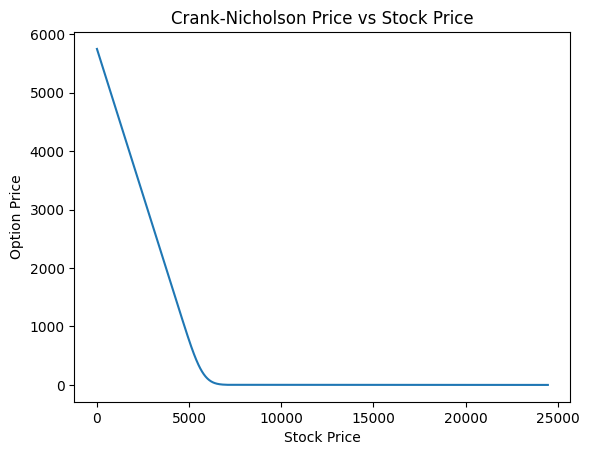

CPU times: user 409 ms, sys: 465 ms, total: 875 ms
Wall time: 291 ms


In [15]:
%%time

cn = CrankNicholson(SMax = spx.info['open']*4, SMin = 0, M = 1000, N = 500)

# plot the price vs stock price
import matplotlib.pyplot as plt
S, price = cn.price(option, market)
data = pd.DataFrame({"S": S, "price": price})
plt.plot(data.S, data.price)
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("Crank-Nicholson Price vs Stock Price")
plt.show()

In [16]:
data[(data['S'] > spx.info['open'] * 0.99) & (data['S'] < spx.info['open'] * 1.01)]

,S,price
748,6164.44416,65.982371
749,6139.98208,71.137160
750,6115.52000,76.612724
751,6091.05792,82.421467
752,6066.59584,88.575632


Now we see that the Crank-Nicolson method gets us very close to the Black-Scholes model. Let us try this with American options.

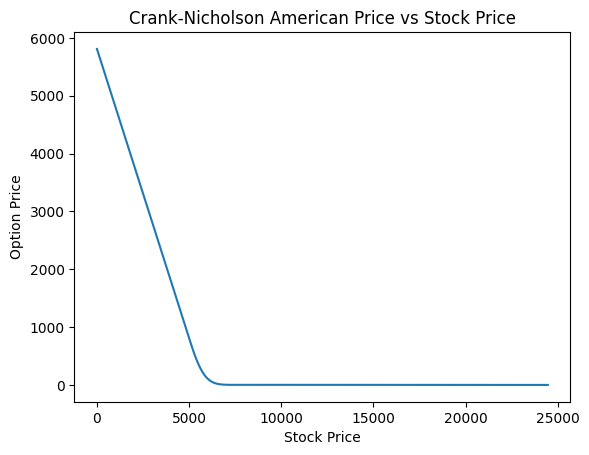

,S,price
748,6164.44416,67.375631
749,6139.98208,72.669803
750,6115.52000,78.297231
751,6091.05792,84.271278
752,6066.59584,90.605202


In [17]:
S2, price2 = cn.price(option, market, american = True)
data2 = pd.DataFrame({"S": S2, "price": price2})
plt.plot(data2.S, data2.price)
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("Crank-Nicholson American Price vs Stock Price")
plt.show()

data2[(data2['S'] > spx.info['open'] * 0.99) & (data2['S'] < spx.info['open'] * 1.01)]

We see that the Crank-Nicolson method is very close to the values for the American options given by the binomial and trinomial trees. Let's look now at pricing for call options.

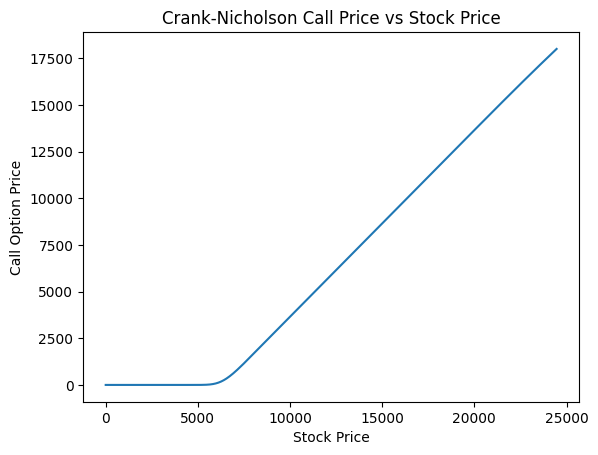

CPU times: user 641 ms, sys: 84.9 ms, total: 725 ms
Wall time: 247 ms


In [18]:
%%time

S_2, price_2 = cn.price(call, market)
data3 = pd.DataFrame({"S": S_2, "price": price_2})
plt.plot(data3.S, data3.price)
plt.xlabel("Stock Price")
plt.ylabel("Call Option Price")
plt.title("Crank-Nicholson Call Price vs Stock Price")
plt.show()

In [19]:
data3[(data3['S'] > spx.info['open'] * 0.99) & (data3['S'] < spx.info['open'] * 1.01)]

,S,price
748,6164.44416,140.804979
749,6139.98208,131.615678
750,6115.52000,122.837408
751,6091.05792,114.465194
752,6066.59584,106.493295


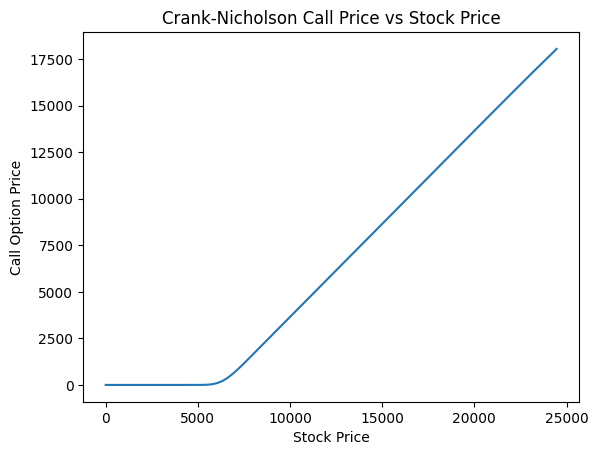

CPU times: user 785 ms, sys: 99.8 ms, total: 884 ms
Wall time: 301 ms


,S,price
748,6164.44416,140.804979
749,6139.98208,131.615678
750,6115.52000,122.837408
751,6091.05792,114.465194
752,6066.59584,106.493295


In [20]:
%%time

S_3, price_3 = cn.price(call, market, american = True)
data4 = pd.DataFrame({"S": S_3, "price": price_3})
plt.plot(data4.S, data4.price)
plt.xlabel("Stock Price")
plt.ylabel("Call Option Price")
plt.title("Crank-Nicholson Call Price vs Stock Price")
plt.show()

data4[(data4['S'] > spx.info['open'] * 0.99) & (data4['S'] < spx.info['open'] * 1.01)]

## Pricing Vanilla Options with Monte Carlo
Now, let us try to price our options using Monte Carlo methods. We will use the same data as above and price the same options.

There are different forms of Monte Carlo methods. Let's first investigate the naive Monte Carlo method which is the most basic form of Monte Carlo methods. 

Some additional comments:
- For European options, the naive Monte Carlo method will work but it is not very efficient. The reason is that we are generating a lot of paths that are not needed. We will see this when we try to price it.
- For American options, the naive Monte Carlo method will not work because we need to know the value of the option at each time step and we are only generating one path, but we can use the Longstaff-Schwartz method to price American options. Because this method is largely slower than even the binomial tree method, we will not implement it here.

#### Naive Monte Carlo for European Options

In [21]:
def NaiveMonteCarlo(option: European, market: MarketData, N: int) -> float:
    Z = np.random.normal(size = N)
    S_T = market.S * np.exp((market.r - market.q - 0.5 * market.sigma ** 2) * option.T + market.sigma * np.sqrt(option.T) * Z)

    if option.is_call:
        payoff = np.maximum(S_T - option.K, 0)
    else:
        payoff = np.maximum(option.K - S_T, 0)

    return np.exp(-market.r * option.T) * np.mean(payoff)

In [22]:
%%time

mc_price = NaiveMonteCarlo(option, market, N = 100000)
print(f"Monte Carlo Price: {mc_price}")

Monte Carlo Price: 77.0554653338003
CPU times: user 13.8 ms, sys: 5.46 ms, total: 19.3 ms
Wall time: 7.2 ms


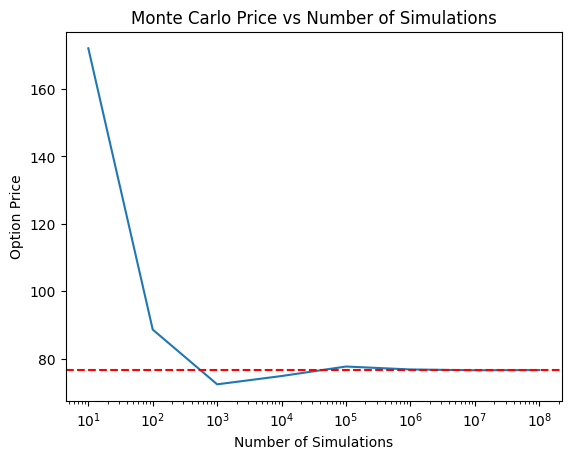

In [23]:
data = pd.DataFrame({"N": [10 ** (i + 1) for i in range(8)]})
data["Price"] = data.N.apply(lambda x: NaiveMonteCarlo(option, market, N = x))

plt.plot(data.N, data.Price)
plt.xscale("log")
plt.xlabel("Number of Simulations")
plt.ylabel("Option Price")
plt.title("Monte Carlo Price vs Number of Simulations")
#plot bs price line
plt.axhline(y = bs_price, color = 'r', linestyle = '--', label = 'Black Scholes Price')
plt.show()

We see that although with an increasing number of paths, the naive Monte Carlo method converges to the Black-Scholes model, it is not very efficient. In fact, our convergence by CLT follows:
$$
\frac{\hat{C}_{\text{MC}}-\mathbb{E}[C]}{\hat{\sigma}}\to \mathcal{N}(0,1)
$$
This gives us a 95% confidence interval of:
$$
\left(\hat{C}_{\text{MC}}-1.96\frac{\hat{\sigma}}{\sqrt{N}}, \hat{C}_{\text{MC}}+1.96\frac{\hat{\sigma}}{\sqrt{N}}\right)
$$

Think about this for a second. Let's say we have $\hat{\sigma} = 0.2$ and $N = 100$. This gives us a confidence interval width of $1.96\frac{0.2}{\sqrt{100}} = 0.0392$. So to increase the accuracy of our estimate, we need to increase $N$ which is the number of paths we generate. This is not very efficient. Hence, we have to use variance reduction techniques to increase the efficiency of our estimate.

#### Antithetic Variates
In a naive model, we generate multiple paths and take the average. But we can do better. What if we generated a path from a $q$ percentile and a path from a $1-q$ percentile and take the average of the two paths? This kind of method is called antithetic variates. This method is very efficient because it reduces the variance of our estimate.

For example, for each path $n = 1,2,\ldots,N$ we let:
$$
\begin{align*}
\tilde{Z}_n &= -Z_n \\
C_n &= e^{-rT}\max\{0, S_0e^{r - \frac{\sigma^2}{2}T + \sigma\sqrt{T}Z_n} - K\} \\
\tilde{C}_n &= e^{-rT}\max\{0, S_0e^{r - \frac{\sigma^2}{2}T + \sigma\sqrt{T}\tilde{Z}_n} - K\}\\
C_{n}^{\text{average}} &= \frac{1}{2}\left(C_n + \tilde{C}_n\right)\\
\hat{C}_{\text{N}}^{\text{average}} &= \frac{1}{N}\sum_{n=1}^{N}C_{n}^{\text{average}}
\end{align*}
$$

You see that:
$$
\mathbb{E}[\hat{C}_{N}^{\text{average}}] = \frac{1}{N}\sum_{n=1}^{N}\mathbb{E}[C_{n}^{\text{average}}] = \mathbb{E}[0.5(C_n + \tilde{C}_n)] = \mathbb{E}[C_n] = C
$$

We also see that:
$$
\text{Var}[\hat{C}_{N}^{\text{average}}] = \frac{1}{N}\left(\frac{1}{2}\text{Var}[C_n] + \frac{1}{2}\text{Var}[\tilde{C}_n] + \text{Cov}(C_n, \tilde{C}_n)\right)
$$

This means we just have to make sure $\text{Cov}(C_n, \tilde{C}_n)$ is negative to reduce the variance of our estimate.

In [24]:
def antithetic_mc(option: European, market: MarketData, N: int) -> float:
    Z = np.random.normal(size = int(N/2))
    S_T1 = market.S * np.exp((market.r - market.q - 0.5 * market.sigma ** 2) * option.T + market.sigma * np.sqrt(option.T) * Z)
    S_T2 = market.S * np.exp((market.r - market.q - 0.5 * market.sigma ** 2) * option.T - market.sigma * np.sqrt(option.T) * Z)

    if option.is_call:
        payoff1 = np.maximum(S_T1 - option.K, 0)
        payoff2 = np.maximum(S_T2 - option.K, 0)
    else:
        payoff1 = np.maximum(option.K - S_T1, 0)
        payoff2 = np.maximum(option.K - S_T2, 0)

    return np.exp(-market.r * option.T) * (np.mean(payoff1) + np.mean(payoff2)) / 2

Antithetic Monte Carlo Price: 75.49149868994049


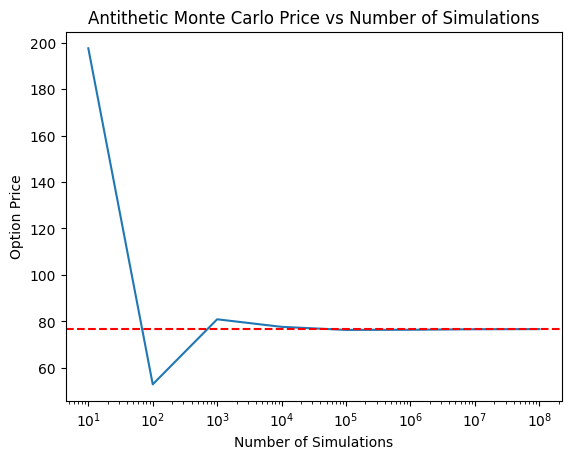

CPU times: user 2.95 s, sys: 1.02 s, total: 3.97 s
Wall time: 3.5 s


In [25]:
%%time

mc_price = antithetic_mc(option, market, N = 100000)
print(f"Antithetic Monte Carlo Price: {mc_price}")

data = pd.DataFrame({"N": [10 ** (i + 1) for i in range(8)]})
data["Price"] = data.N.apply(lambda x: antithetic_mc(option, market, N = x))
plt.plot(data.N, data.Price)
plt.xscale("log")
plt.xlabel("Number of Simulations")
plt.ylabel("Option Price")
plt.title("Antithetic Monte Carlo Price vs Number of Simulations")
#plot bs price line
plt.axhline(y = bs_price, color = 'r', linestyle = '--', label = 'Black Scholes Price')
plt.show()

You see that the antithetic variates method converges much faster than the naive Monte Carlo method. This is because we are generating two paths for each path we generate in the naive Monte Carlo method. This means we are generating $2N$ paths instead of $N$ paths. This is much more efficient.

## Pricing Exotic Options
Now, let us try to price some exotic options. In particular, we will use the same data as above and price the different types of options.

In particular we will price:
- Barrier options
- Cliquets
- Worst-of options
- Dispersion options

### Pricing Barrier Options
Barrier options are options that have a payoff that depends on the price of the underlying asset at a certain barrier level. There are two types of barrier options:
- Knock-in options: options that become active when the price of the underlying asset hits a certain barrier level.
- Knock-out options: options that become inactive when the price of the underlying asset hits a certain barrier level.
There are also two types of barrier options:
- Up-and-out options: options that become inactive when the price of the underlying asset hits a certain barrier level above the current price.
- Down-and-out options: options that become inactive when the price of the underlying asset hits a certain barrier level below the current price.
- Up-and-in options: options that become active when the price of the underlying asset hits a certain barrier level above the current price.
- Down-and-in options: options that become active when the price of the underlying asset hits a certain barrier level below the current price.

Here we will implement a function that prices barrier options using Finite Difference as well as Monte Carlo methods.

In [26]:
class CrankNicholsonBarrier:
    def __init__(self, SMax: float, SMin: float, M: float, N: float) -> None:
        self.SMax = SMax
        self.SMin = SMin
        self.M = M
        self.N = N

    def price(self, option: European, market: MarketData, barrier_level: float = None, 
              barrier_dir: str = 'D', in_out: str = 'O', observationinterval: float = 1) -> tuple:
        deltat = option.T / self.N
        deltas = (self.SMax - self.SMin) / self.M

        S = np.linspace(self.SMax, self.SMin, self.M + 1)  
        observation_steps = int(observationinterval/deltat) if barrier_level else 1

        # Initialize prices
        if option.is_call:
            price = np.maximum(S - option.K, 0)
        else:
            price = np.maximum(option.K - S, 0)
        # we are going to use the trick where a knock out option plus a knock in option equals a vanilla option
        ko_price = price.copy()

        ratio1 = deltat/deltas
        ratio2 = deltat/(deltas**2)
        f = 0.5 * (market.sigma**2)*(S**2)
        g = (market.r - market.q)*S
        h = -market.r * np.ones_like(S)
        F = (0.5*ratio2*f) + (0.25*ratio1*g)
        G = (ratio2*f) - (0.5*deltat*h)
        H = (0.5*ratio2*f) - (0.25*ratio1*g)

        # unchangewd matrices same as last process
        LHSmatrix = diags([-H[:-1], 1 + G, -F[1:]], [1, 0, -1], 
                         shape=(self.M+1, self.M+1), format='csr')
        RHSmatrix = diags([H[:-1], 1 - G, F[1:]], [1, 0, -1],
                         shape=(self.M+1, self.M+1), format='csr')

        for step in range(self.N-1, -1, -1):
            if option.is_call:
                rhs = RHSmatrix @ price
                rhs[0] += 2*F[0]*((S[0]-option.K) - (S[0]-S[1]))
                ko_rhs = RHSmatrix @ ko_price
                ko_rhs[0] += 2*F[0]*((S[0]-option.K) - (S[0]-S[1]))
            else:
                rhs = RHSmatrix @ price
                rhs[-1] += 2*H[-1]*(option.K - (self.SMin - deltas))
                ko_rhs = RHSmatrix @ ko_price
                ko_rhs[-1] += 2*H[-1]*(option.K - (self.SMin - deltas))

            price = spsolve(LHSmatrix, rhs)
            ko_price = spsolve(LHSmatrix, ko_rhs)

            # apply barrier
            if barrier_level and (step % observation_steps == 0):
                barrier_idx = np.argmax(S <= barrier_level)   
                if barrier_dir == 'D':  # Down-and-out: KO if S <= barrier
                    ko_price[barrier_idx:] = 0  # set prices to be zero BELOW barrier
                else:  # Up-and-out: KO if S >= barrier
                    ko_price[:barrier_idx] = 0  # set prices to be zero ABOVE barrier

        # Calculate knock-in price
        ki_price = price - ko_price
        
        return (S, ki_price, ko_price, price)

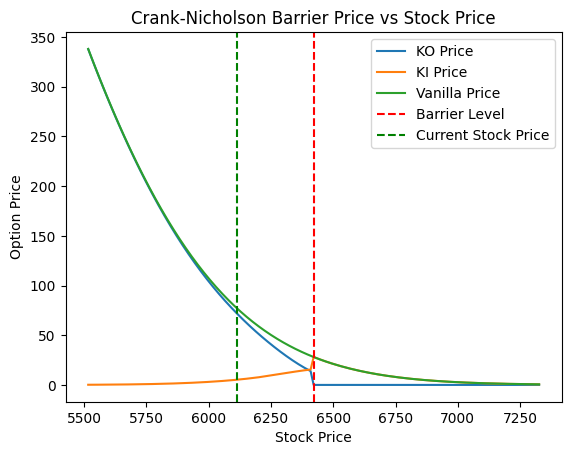

,S,KO,KI,VAN
496,6164.44416,59.382872,6.584292,65.967164
497,6152.21312,62.267671,6.237624,68.505295
498,6139.98208,65.215511,5.906552,71.122064
499,6127.75104,68.228516,5.590516,73.819032
500,6115.52000,71.308815,5.288939,76.597754
501,6103.28896,74.458527,5.001249,79.459776
502,6091.05792,77.679744,4.726892,82.406635
503,6078.82688,80.974519,4.465336,85.439855
504,6066.59584,84.344870,4.216076,88.560946
505,6054.36480,87.792772,3.978630,91.771402


In [27]:
barrier_price = CrankNicholsonBarrier(SMax = spx.info['open']*2, SMin = 0, M = 1000, N = 500)
barrier_level = spx.info['open'] * 1.05
call = European(K = spx.info['open'], T = 0.25, is_call = True) # call option

S_0, KI, KO, VAN = barrier_price.price(option, market, barrier_level = barrier_level, barrier_dir = 'U', in_out = 'O', observationinterval = 0.01)
data = pd.DataFrame({"S": S_0, "KO": KO, "KI": KI, "VAN": VAN})
# plot only data 0.8 and 1.2
plt.plot(data[(data['S'] > spx.info['open'] * 0.9) & (data['S'] < spx.info['open'] * 1.2)]['S'], data[(data['S'] > spx.info['open'] * 0.9) & (data['S'] < spx.info['open'] * 1.2)]['KO'], label = "KO Price")
plt.plot(data[(data['S'] > spx.info['open'] * 0.9) & (data['S'] < spx.info['open'] * 1.2)]['S'], data[(data['S'] > spx.info['open'] * 0.9) & (data['S'] < spx.info['open'] * 1.2)]['KI'], label = "KI Price")
plt.plot(data[(data['S'] > spx.info['open'] * 0.9) & (data['S'] < spx.info['open'] * 1.2)]['S'], data[(data['S'] > spx.info['open'] * 0.9) & (data['S'] < spx.info['open'] * 1.2)]['VAN'], label = "Vanilla Price")
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("Crank-Nicholson Barrier Price vs Stock Price")
plt.axvline(x = barrier_level, color = 'r', linestyle = '--', label = 'Barrier Level')
plt.axvline(x = spx.info['open'], color = 'g', linestyle = '--', label = 'Current Stock Price')
plt.legend()
plt.show()

data[(data['S'] > spx.info['open']* 0.99) & (data['S'] < spx.info['open'] * 1.01)]

Now, let us try to price barrier options using monte carlo method with antithetic variates instead.

In [28]:
def montecarlobarrier(
    option: European, 
    market: MarketData, 
    N: int, 
    barrier_level: float = None, 
    barrier_dir: str = 'D', 
    in_out: str = 'O', 
    observationinterval: float = 1
) -> tuple:
    
    dt = observationinterval
    n_steps = int(option.T / dt)
    n_simulations = N  # total path including antithetics

    Z = np.random.normal(size=(n_steps, n_simulations // 2))
    Z_antithetic = -Z  # antithetic variates

    # function to simulate paths
    def simulate_paths(z):
        log_S = np.zeros((n_steps + 1, z.shape[1]))
        log_S[0] = np.log(market.S)
        drift = (market.r - market.q - 0.5 * market.sigma**2) * dt
        vol = market.sigma * np.sqrt(dt)
        for t in range(1, n_steps + 1):
            log_S[t] = log_S[t-1] + drift + vol * z[t-1]
        return np.exp(log_S)

    S_paths1 = simulate_paths(Z)
    S_paths2 = simulate_paths(Z_antithetic)
    S_paths = np.concatenate([S_paths1, S_paths2], axis=1)

    # check barrier
    if barrier_dir == 'D':
        barrier_breached = np.any(S_paths <= barrier_level, axis=0)
    else:
        barrier_breached = np.any(S_paths >= barrier_level, axis=0)

    ST = S_paths[-1]
    if option.is_call:
        payoff_vanilla = np.maximum(ST - option.K, 0)
    else:
        payoff_vanilla = np.maximum(option.K - ST, 0)

    # apply barrier condition
    if in_out == 'O':
        payoff_ko = payoff_vanilla.copy()
        payoff_ko[barrier_breached] = 0
        payoff_ki = payoff_vanilla.copy()
        payoff_ki[~barrier_breached] = 0
    else:  # 'I' for knock-in
        payoff_ki = payoff_vanilla.copy()
        payoff_ki[~barrier_breached] = 0
        payoff_ko = payoff_vanilla.copy()
        payoff_ko[barrier_breached] = 0

    discount = np.exp(-market.r * option.T)
    vanilla_price = discount * np.mean(payoff_vanilla)
    ko_price = discount * np.mean(payoff_ko)
    ki_price = discount * np.mean(payoff_ki)

    # check if KI + KO = Vanilla
    assert np.isclose(ki_price + ko_price, vanilla_price, rtol=1e-3), \
        "Violation: KI + KO ≠ Vanilla"

    return vanilla_price, ki_price, ko_price

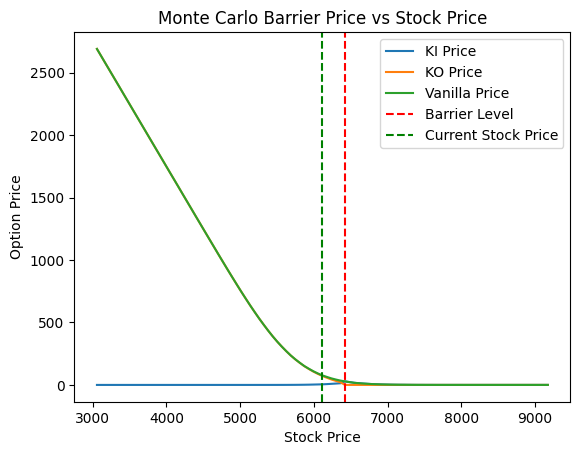

In [29]:
# build a dataframe of prices for each S so we can plot it
barrier_level = spx.info['open'] * 1.05
data = pd.DataFrame({"S": [spx.info['open'] * (1 + i/100) for i in range(-50, 51)]})

data["Price"], data["KI"], data["KO"] = zip(*data["S"].apply(lambda x: montecarlobarrier(option,
                                                                                         MarketData(S = x, r = market.r, q = market.q, sigma = market.sigma),
                                                                                         N = 100000,
                                                                                         barrier_level = barrier_level,
                                                                                         barrier_dir = 'U',
                                                                                         in_out = 'O',
                                                                                         observationinterval = 0.01)))


plt.plot(data.S, data.KI, label = "KI Price")
plt.plot(data.S, data.KO, label = "KO Price")
plt.plot(data.S, data.Price, label = "Vanilla Price")
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("Monte Carlo Barrier Price vs Stock Price")
plt.axvline(x = barrier_level, color = 'r', linestyle = '--', label = 'Barrier Level')
plt.axvline(x = spx.info['open'], color = 'g', linestyle = '--', label = 'Current Stock Price')
plt.legend()
plt.show()


In [30]:
data[(data['S'] > spx.info['open'] * 0.95) & (data['S'] < spx.info['open'] * 1.05)]

,S,Price,KI,KO
46,5870.8992,151.142925,1.464057,149.678869
47,5932.0544,129.479706,2.052311,127.427395
48,5993.2096,109.336964,2.921127,106.415837
49,6054.3648,91.925788,3.843715,88.082073
50,6115.5200,76.290487,4.729060,71.561427
51,6176.6752,63.917050,6.534915,57.382134
52,6237.8304,52.298683,8.756944,43.541739
53,6298.9856,43.013204,10.965139,32.048065
54,6360.1408,34.694556,13.340058,21.354497


### Pricing Cliquets
Cliquets are a form of exotic forward start options, i.e. options that have a payoff that depends on the price of the underlying asset at a certain time in the future. In particular we will price a cliquet option with a 3M maturity and a 1M reset period. Meaning our payoff at maturity is:
$$
\sum_{i=1}^{3}\max\{\min{\frac{S_{T_i}}{S_{T_{i-1}}}-1, \text{cap}}, \text{floor}\}
$$
where $T_i$ is the time of the $i$-th reset period.

How can we do this? We follow a 3 step guidelines:
1. Each period would require some forward start volatility. We can try to use a Heston model to get the forward start volatility.
2. Simulate the underlying asset price at each reset date
3. Apply constraints before computing the payoff.

Additional comments:
We follow Heston model such that:
$$
\begin{align*}
dS_t &= (r-q)S_tdt + \sqrt{v_t}S_tdW_t^S \\
dv_t &= \kappa(\theta - v_t)dt + \sigma_v\sqrt{v_t}dW_t^v
\end{align*}
$$
where $dW_t^S$ (asset noise) and $dW_t^v$ (volatility noise) are correlated with $\rho$, $\theta$ is the long run average variance, $\kappa$ is the rate of mean reversion, $\sigma_v$ is the volatility of volatility, and $v_t$ is the variance process.

We will use some example numbers to price these.

In [31]:
class CliquetPricer:
    def __init__(self, S0: float, r: float, q: float, T: float, 
                 n_resets: int, local_cap: float, local_floor: float,
                 kappa: float, theta: float, sigma_v: float, rho: float, v0: float):
        self.S0 = S0
        self.r = r
        self.q = q
        self.T = T
        self.n_resets = n_resets
        self.local_cap = local_cap
        self.local_floor = local_floor
        self.kappa = kappa        # Heston mean reversion speed
        self.theta = theta        # Heston long-term vol
        self.sigma_v = sigma_v    # Vol of vol
        self.rho = rho            # Correlation S and vol
        self.v0 = v0              # Initial volatility
        
    def price(self, n_simulations: int = 100000) -> float:
        dt = self.T / self.n_resets
        reset_times = np.linspace(dt, self.T, self.n_resets)
        
        S = np.full((n_simulations, self.n_resets + 1), self.S0)
        v = np.full((n_simulations, self.n_resets + 1), self.v0)
        returns = np.zeros((n_simulations, self.n_resets))

        Z_S = np.random.normal(size=(n_simulations, self.n_resets))
        Z_v = self.rho * Z_S + np.sqrt(1 - self.rho**2) * np.random.normal(size=(n_simulations, self.n_resets))
        
        for i in range(1, self.n_resets + 1):
            v_prev = v[:, i-1]
            v[:, i] = np.maximum(v_prev + self.kappa * (self.theta - v_prev) * dt 
                                 + self.sigma_v * np.sqrt(v_prev * dt) * Z_v[:, i-1], 0)
            
            S_prev = S[:, i-1]
            S[:, i] = S_prev * np.exp(
                (self.r - self.q - 0.5 * v_prev) * dt 
                + np.sqrt(v_prev * dt) * Z_S[:, i-1]
            )

            # apply local cap and floor            
            ret = (S[:, i] / S_prev - 1)
            returns[:, i-1] = np.clip(ret, self.local_floor, self.local_cap)
        
        total_payoff = np.sum(returns, axis=1)
        price = np.exp(-self.r * self.T) * np.mean(total_payoff)
        
        return price


In [32]:
cliquet = CliquetPricer(
    S0 = market.S,
    r = market.r,
    q = 0,
    T = option.T,
    n_resets = 3,
    local_cap = 0.2,
    local_floor = -0.1,
    kappa = 1.5,
    theta = 0.18**2,
    sigma_v = 0.6,
    rho = -0.7,
    v0 = vix3m.info["open"]/100**2
)

price = cliquet.price(n_simulations=100000)
print(f"Cliquet option price: {price:.4f}")

Cliquet option price: 0.0106


### Pricing Worst-of Options
While I was in asia, this was the primary exotic that was traded, i.e. worst-of options out of 2 or more assets. Because the put is traded much more often to facilitate yield, I will just implement the put option.

Consider an investor who structures a worst-of option on two assets $S_1$ and $S_2$ at strike of $100\%$ of the initial price (we are simplifying this problem). In our world previously, this would be the payoff of:
$$
\max\left\{0, \frac{S_1^0-S_1^T}{S_1^0}, \frac{S_2^0-S_2^T}{S_2^0}\right\}
$$
where $S_1^0$ and $S_2^0$ are the initial prices of the assets and $S_1^T$ and $S_2^T$ are the prices of the assets at maturity.

We will price this using a antithetic Monte Carlo method, taking into account the correlation between the assets, but will simplify the implementation by using \$100 for both underlying asset's initial price and strike.

In [33]:
class WOrstofPut:
    def __init__(self, M: int, seed: int = 42) -> None:
        self.M = M
        self.rng = np.random.default_rng(seed=seed)

    def price_worstof_put_multiGBM(self, dynamics: 'MultiGBM', T: float) -> tuple:
        """
        Prices a worst-of put option using antithetic Monte Carlo.
        
        Args:
            dynamics: Contains S0 (initial prices), r (risk-free rate), 
                     correlations (asset correlation), sigma (volatilities).
            T: Time to maturity.
            
        Returns:
            (price, standard_error)
        """
        S0 = dynamics.S0
        r = dynamics.r
        correlations = dynamics.correlations
        sigma_matrix = dynamics.sigma
        sigma1 = sigma_matrix[0, 0]
        sigma2 = sigma_matrix[1, 1]
        cov_matrix = sigma_matrix @ correlations @ sigma_matrix

        try:
            # correlated Brownian increments but this is not exactly the best way to do this
            Z = self.rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=self.M).T
            W = np.sqrt(T) * Z
        except:
            # if this does not work then we can use Cholesky decomposition
            Z = self.rng.multivariate_normal(mean=[0, 0], cov=np.eye(2), size=self.M).T
            L = np.linalg.cholesky(cov_matrix * T)
            W = np.matmul(L, Z)

        drift1 = (r - 0.5 * sigma1**2) * T
        drift2 = (r - 0.5 * sigma2**2) * T
        
        # Original paths
        S1 = S0[0] * np.exp(drift1 + sigma1 * W[0])
        S2 = S0[1] * np.exp(drift2 + sigma2 * W[1])

        # Antithetic paths
        W_anti = -W  # Negate Brownian increments
        S1_anti = S0[0] * np.exp(drift1 + sigma1 * W_anti[0])
        S2_anti = S0[1] * np.exp(drift2 + sigma2 * W_anti[1])

        # Payoff calculation
        rel_loss1 = (S0[0] - S1) / 100
        rel_loss2 = (S0[1] - S2) / 100
        worst_loss = np.maximum(rel_loss1, rel_loss2)
        payoff = np.maximum(worst_loss, 0)
        discounted_payoff = np.exp(-r * T) * payoff

        # Antithetic payoff
        rel_loss1_anti = (S0[0] - S1_anti) / 100
        rel_loss2_anti = (S0[1] - S2_anti) / 100
        worst_loss_anti = np.maximum(rel_loss1_anti, rel_loss2_anti)
        payoff_anti = np.maximum(worst_loss_anti, 0)
        discounted_payoff_anti = np.exp(-r * T) * payoff_anti
        
        # Combine antithetic pairs
        combined_payoffs = 0.5 * (discounted_payoff + discounted_payoff_anti)
        price = np.mean(combined_payoffs)
        stderr = np.std(combined_payoffs, ddof=1) / np.sqrt(self.M)

        return price, stderr


In [34]:
# example
class MultiGBM:
    def __init__(self, S0: list, r: float, correlations: np.ndarray, sigma: np.ndarray):
        self.S0 = S0
        self.r = r
        self.correlations = correlations
        self.sigma = sigma

dynamics = MultiGBM(
    S0=[100, 100], 
    r=0.05, 
    correlations=np.array([[1.0, 0.5],
                          [0.5, 1.0]]), 
    sigma=np.array([[0.2, 0],
                   [0, 0.25]])
)

T = 1.0
M = 100_000

engine = WOrstofPut(M)
price, stderr = engine.price_worstof_put_multiGBM(dynamics, T)

print(f"Worst-of Put Price: {price:.4f}")
print(f"Standard Error: {stderr:.6f}")

Worst-of Put Price: 0.0173
Standard Error: 0.000049


/var/folders/53/61_6b7sj45b995hfkyjr5lfh0000gn/T/ipykernel_85922/2836365513.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.020053772441277932' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, "price"] = price


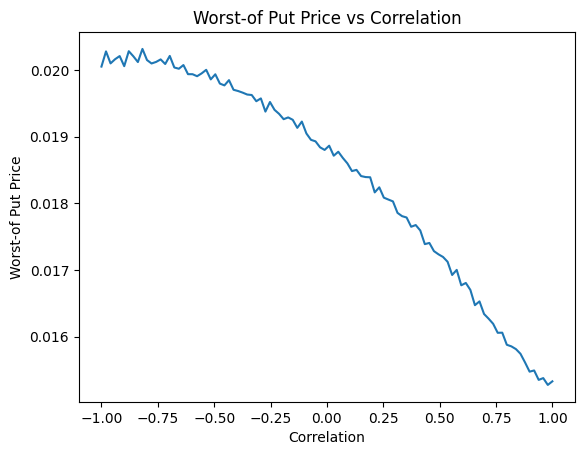

In [35]:
# price change in price relative to change in correlation
corr = np.linspace(-1, 1, 100)

data = pd.DataFrame({"corr": corr})
data["price"] = 0

for i in range(len(corr)):
    dynamics = MultiGBM(
        S0=[100, 100], 
        r=0.05, 
        correlations=np.array([[1.0, corr[i]],
                               [corr[i], 1.0]]), 
        sigma=np.array([[0.2, 0],
                        [0, 0.25]])
    )
    price, stderr = engine.price_worstof_put_multiGBM(dynamics, T)
    data.loc[i, "price"] = price

plt.plot(data["corr"], data["price"])
plt.xlabel("Correlation")
plt.ylabel("Worst-of Put Price")
plt.title("Worst-of Put Price vs Correlation")
plt.show()

We see that, as expected, the worst-of option value rises as the correlation between the assets decrease, which means that the holder is short correlation.

### Pricing Dispersion Options
In this section, we want to talk about a popular exotic option called the dispersion option (at least that is how it is named in Asia). This particular option is a basket option that is based on the correlation between the assets in the basket. 

The payoff is as such:
$$
\max\left\{0, \frac{1}{N}\sum_{i=1}^{N}\left\vert\frac{S_i^T - S_i^0}{S_i^0} - \frac{1}{N}\sum_{i=1}^{N}\frac{S_i^T - S_i^0}{S_i^0}\right\vert - K\right\}
$$
where $S_i^0$ and $S_i^T$ are the initial and final prices of the assets in the basket and $K$ is the strike percentage.

In other words, the payoff is the average of the absolute difference between the percentage change of the assets in the basket and the average percentage change of the assets in the basket.

In [36]:
class Dispersion:
    def __init__(self, M: int, seed: int = 42) -> None:
        self.M = M
        self.rng = np.random.default_rng(seed=seed)

    def price_dispersion_option(self, dynamics: 'MultiGBM', T: float, K: float) -> tuple:
        """
        Prices a dispersion option using antithetic Monte Carlo.
        
        Args:
            dynamics: Contains S0 (initial prices), r (risk-free rate), 
                     correlations (asset correlation), sigma (volatilities).
            T: Time to maturity.
            K: Strike percentage.
            
        Returns:
            (price, standard_error)
        """
        S0 = np.array(dynamics.S0)
        r = dynamics.r
        correlations = dynamics.correlations
        sigma_matrix = dynamics.sigma
        N_assets = len(S0)
        def stabilize_covariance_matrix(matrix, epsilon=1e-6):
            diag_indices = np.diag_indices_from(matrix)
            matrix[diag_indices] += epsilon
            return matrix
        cov_matrix = sigma_matrix @ correlations @ sigma_matrix
        cov_matrix = stabilize_covariance_matrix(cov_matrix)

        try:
            Z = self.rng.multivariate_normal(mean=np.zeros(N_assets), cov=cov_matrix, size=self.M).T
            W = np.sqrt(T) * Z
        except:
            Z = self.rng.multivariate_normal(mean=np.zeros(N_assets), cov=np.eye(N_assets), size=self.M).T
            L = np.linalg.cholesky(cov_matrix * T)
            W = np.matmul(L, Z)

        # simulate asset paths
        S_T = np.zeros((N_assets, self.M))
        for i in range(N_assets):
            drift = (r - 0.5 * sigma_matrix[i, i]**2) * T
            S_T[i] = S0[i] * np.exp(drift + sigma_matrix[i, i] * W[i])

        # payoff calculation
        percentage_changes = (S_T - S0[:, np.newaxis]) / S0[:, np.newaxis]
        avg_percentage_change = np.mean(percentage_changes, axis=0)
        dispersion = np.mean(np.abs(percentage_changes - avg_percentage_change), axis=0)
        payoff = np.maximum(dispersion - K, 0)

        # discounted payoff
        discounted_payoff = np.exp(-r * T) * payoff
        price = np.mean(discounted_payoff)
        stderr = np.std(discounted_payoff, ddof=1) / np.sqrt(self.M)

        return price, stderr

In [37]:
# Example usage
dynamics = MultiGBM(
    S0=[100, 100, 100],  # Three assets
    r=0.05, 
    correlations=np.array([[1.0, 0.5, 0.3],
                          [0.5, 1.0, 0.4],
                          [0.3, 0.4, 1.0]]), 
    sigma=np.array([[0.2, 0, 0],
                   [0, 0.25, 0],
                   [0, 0, 0.3]])
)

T = 1.0
K = 0.02  # Strike percentage
M = 100_000

engine = Dispersion(M)
price, stderr = engine.price_dispersion_option(dynamics, T, K)

print(f"Dispersion Option Price: {price:.4f}")
print(f"Standard Error: {stderr:.6f}")

Dispersion Option Price: 0.0173
Standard Error: 0.000056


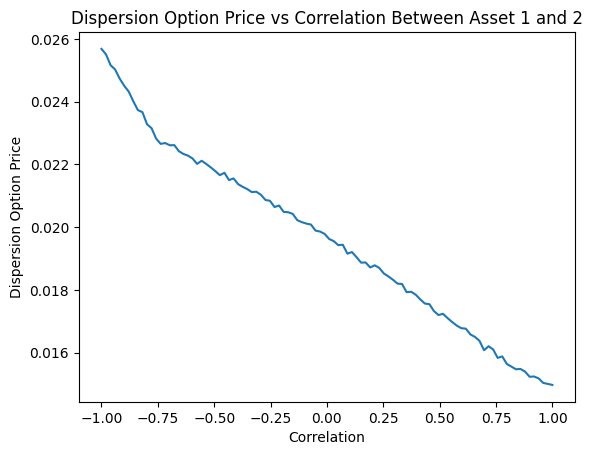

In [38]:
import warnings
warnings.filterwarnings("ignore")

# price change in price relative to change in correlation
corr = np.linspace(-1, 1, 100)
data = pd.DataFrame({"corr": corr})
data["price"] = 0

for i in range(len(corr)):
    dynamics = MultiGBM(
        S0=[100, 100, 100],  # Three assets
        r=0.05, 
        correlations=np.array([[1.0, corr[i], 0.3],
                               [corr[i], 1.0, 0.4],
                               [0.3, 0.4, 1.0]]), 
        sigma=np.array([[0.2, 0, 0],
                       [0, 0.25, 0],
                       [0, 0, 0.3]])
    )
    price, stderr = engine.price_dispersion_option(dynamics, T, K)
    data.loc[i, "price"] = price

plt.plot(data["corr"], data["price"])
plt.xlabel("Correlation")
plt.ylabel("Dispersion Option Price")
plt.title("Dispersion Option Price vs Correlation Between Asset 1 and 2")
plt.show()

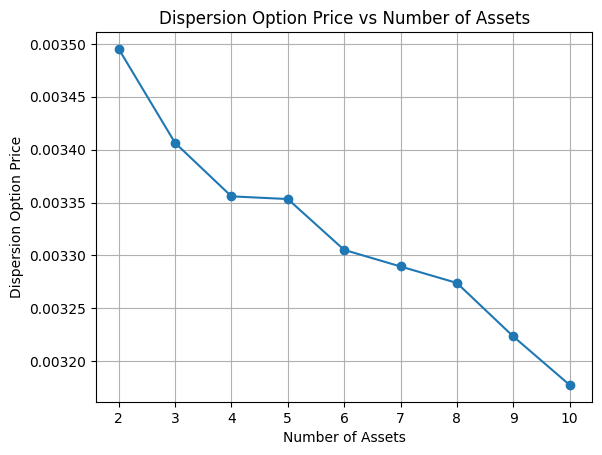

In [39]:
N_assets = np.arange(2, 11)
data = pd.DataFrame({"N_assets": N_assets})
data["price"] = 0

for i in range(len(N_assets)):
    correlations = np.full((N_assets[i], N_assets[i]), 0.5)
    np.fill_diagonal(correlations, 1)
    
    sigma = np.diag([0.2] * N_assets[i])

    dynamics = MultiGBM(
        S0=[100] * N_assets[i],
        r=0.05, 
        correlations=correlations,
        sigma=sigma
    )
    
    price, stderr = engine.price_dispersion_option(dynamics, T, K)
    data.loc[i, "price"] = price

plt.plot(data["N_assets"], data["price"], marker='o')
plt.xlabel("Number of Assets")
plt.ylabel("Dispersion Option Price")
plt.title("Dispersion Option Price vs Number of Assets")
plt.grid()
plt.show()